In [13]:
# Load project functions
import crypto_monetary_base as cmb

In [101]:
import datetime
import math

import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import gauss
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [15]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.8.6 64bit [GCC 10.2.1 20210110]
IPython 7.19.0
OS Linux 5.10.0 2 amd64 x86_64 with glibc2.29
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
Thu Feb 11 22:33:02 2021 EST

## Supply Curve Calculation

In [129]:
COIN_SYMBOL = 'FIL'

# See https://filecoin.io/blog/filecoin-circulating-supply/
TOTAL_MINTING = 1_100_000_000

# Display ticks
OUTPUT_GRANULARITY = 10000

## See https://spec.filecoin.io/#section-systems.filecoin_token.block_reward_minting
# Epoch is 30 sec
EPOCH_SECS = 30
SECS_PER_YEAR = 365*24*60*60
EPOCH_PER_YEAR = SECS_PER_YEAR/EPOCH_SECS

# Lambda specifies the half-life of the issuance exponential decay function:
# this sets lambda such that the half life is six years (wrt no. of epochs)

# lambda = ln(2) / (6 * epochsInYear)
LAMBDA = math.log(2)/(6*EPOCH_PER_YEAR)

# Initial params
# See https://spec.filecoin.io/#section-algorithms.cryptoecon.initial-parameter-recommendation

# baseline initial value = 2.5057116798121726 EiB
BASELINE_INITIAL_VALUE = 2_888_888_880_000_000_000

# baseline annual growth rate = 100%
BASELINE_ANNUAL_G = 1

# used in the equation to calculate effective network time
# wrt epoch (which is what E.N.T. is denominated in)
BASELINE_G = math.log(1 + BASELINE_ANNUAL_G)/EPOCH_PER_YEAR

# Simulate evolution in effective network time as a Gaussian random walk with these params.
# INITIAL_POWER = BASELINE_INITIAL_VALUE * 0.2 # Start at 20% of target
INITIAL_POWER = BASELINE_INITIAL_VALUE * 0.01
# GAUSSIAN_ANNUAL_G = 0.9 * BASELINE_ANNUAL_G # 90% of target growth each year
GAUSSIAN_ANNUAL_G = 0.5 * BASELINE_ANNUAL_G
GAUSSIAN_GRANULARITY = OUTPUT_GRANULARITY # adjust once per display tick (~3 days)
GAUSSIAN_MEAN = math.log(1 + GAUSSIAN_ANNUAL_G)*GAUSSIAN_GRANULARITY/EPOCH_PER_YEAR
GAUSSIAN_STDEV = 0.68 * GAUSSIAN_MEAN # normal distribution

# γ is the mixture between baseline and simple minting.
# A γ value of 1.0 corresponds to pure baseline minting,
# while a γ value of 0.0 corresponds to pure simple minting.
GAMMA_INITIAL = 0.7

# move gamma by GAMMA_ADJUST every GAMMA_GRANULARITY epochs
GAMMA_GRANULARITY = EPOCH_PER_YEAR

# increase to 1.0 over 50 years
GAMMA_ADJUST = (1-GAMMA_INITIAL)/50

In [112]:
# Recalculate breakdown between simple and baseline as gamma changes
def compute_simple_total(gamma):
    return TOTAL_MINTING * (1-gamma)

def compute_baseline_total(gamma):
    return TOTAL_MINTING * gamma

# Effective network time is a function of initial baseline, baseline growth, and
# realized cumsum (cumulative capped raw-byte power, i.e., realized spacetime, bytes x epochs).
def compute_effective_network_time(cumsumRealized):
    return (1/BASELINE_G)*math.log((BASELINE_G*cumsumRealized/BASELINE_INITIAL_VALUE)+1)

# Baseline supply at effective network time theta
def compute_baseline_supply(theta, gamma):
    return compute_baseline_total(gamma) * (1 - (math.exp(-1 * theta * LAMBDA)))

def compute_simple_supply(epoch, gamma):
    return compute_simple_total(gamma) * (1 - math.exp(-1 * epoch * LAMBDA))

In [119]:
def fil_supply_curve(num_epochs):
    out = [
        # Block num,
        # y_1: Simple supply,
        # y_2: Baseline supply,
        # y_3
        # y_4
        # y_5
    ]
    y_1 = 0
    y_2 = 0
    y_3 = 0
    y_4 = 0
    y_5 = 0
    epoch = 0
    currPower = INITIAL_POWER
    cumsumRealized = 0
    gamma = GAMMA_INITIAL
    for epoch in tqdm.notebook.tqdm(range(1, num_epochs+1)):
        epoch += 1
        if gamma > 0 and gamma < 1 and (epoch-1) % GAMMA_GRANULARITY == 0:
            gamma = gamma + GAMMA_ADJUST

        if (epoch-1) % OUTPUT_GRANULARITY == 0:
            ## FIXED GAMMA, MAX ENT
            
            # simple supply
            y_1 = compute_simple_supply(epoch, GAMMA_INITIAL)
            
            # baseline supply (assume max. E.N.T., theta == epoch)
            y_2 = compute_baseline_supply(epoch, GAMMA_INITIAL)

            ## FIXED GAMMA, RANDOM ENT
            theta = min(compute_effective_network_time(cumsumRealized), epoch)
            y_3 = compute_baseline_supply(theta, GAMMA_INITIAL)
            
            # Model effective network time using a Gaussian random walk
            currPower *= (1+gauss(GAUSSIAN_MEAN, GAUSSIAN_STDEV))
            cumsumRealized += currPower * OUTPUT_GRANULARITY # add spacetime

            ## MOVING GAMMA, MAX ENT

            # Calculating supply when gamma is moving is trickier since incremental supply can turn
            # negative or exceed total minting. To prevent this, we never let supply decline or
            # exceed this amount.

            # simple supply
            y_4 = min(max(compute_simple_supply(epoch, gamma), y_3), TOTAL_MINTING - y_5)

            # baseline supply (assume max. E.N.T., theta == epoch)
            y_5 = min(max(compute_baseline_supply(epoch, gamma), y_4), TOTAL_MINTING - y_4)
            
            out.append([epoch, gamma, y_1, y_2, y_3, y_4, y_5])
            
    return out

In [120]:
def datetime_fil_supply_curve(
    start_date,
    epoch_time,
    supply,
    output_granularity=10000,
    ):
    df = pd.DataFrame(
        supply, columns=['epoch', 'gamma', 'simple_fixed', 'baseline_fixed', 'baseline_fixed_walk', 'simple_moving', 'baseline_moving']
    )
    df['simple_fixed_pct'] = (
        df['simple_fixed'] / df['simple_fixed'].values[-1]
        * 100
    )
    df['baseline_fixed_pct'] = (
        df['baseline_fixed'] / df['baseline_fixed'].values[-1]
        * 100
    )
    df['baseline_fixed_walk_pct'] = (
        df['baseline_fixed_walk'] / df['baseline_fixed_walk'].values[-1]
        * 100
    )
    df['simple_moving_pct'] = (
        df['simple_moving'] / df['simple_moving'].values[-1]
        * 100
    )
    df['baseline_moving_pct'] = (
        df['baseline_moving'] / df['baseline_moving'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=epoch_time * output_granularity,
        periods=len(df)
    )
    return df

In [121]:
def plot_fil_supply_curve(
    supply,
    coin_name=COIN_SYMBOL,
    plot_pct=False,
    max_size=10000,
    out_name='',
    ):
    
    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
#     color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('issuance')
    
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    ## TOTAL
    values = supply.simple_fixed.values[::step_size]+supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='total',
#         color='red',
    )
    
    ## FIXED GAMMA
    
    # Simple
    if plot_pct:
        values = supply.simple_fixed_pct.values[::step_size]
    else:
        values = supply.simple_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='simple-fixed',
#         color='green',
    )
    
    # Baseline
    if plot_pct:
        values = supply.baseline_fixed_pct.values[::step_size]
    else:
        values = supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline-fixed',
#         color='orange',
    )
    
    # Baseline with theta random walk
    if plot_pct:
        values = supply.baseline_fixed_walk_pct.values[::step_size]
    else:
        values = supply.baseline_fixed_walk.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline-fixed-walk',
#         color='orange',
    )
    
#     ## MOVING GAMMA

#     # Simple
#     if plot_pct:
#         values = supply.simple_moving_pct.values[::step_size]
#     else:
#         values = supply.simple_moving.values[::step_size]
#     ax1.plot_date(
#         dates,
#         values,
#         fmt='--',
#         lw=4,
#         label='simple-moving',
# #         color='yellow',
#     )
    
#     # Baseline
#     if plot_pct:
#         values = supply.baseline_moving_pct.values[::step_size]
#     else:
#         values = supply.baseline_moving.values[::step_size]
#     ax1.plot_date(
#         dates,
#         values,
#         fmt='--',
#         lw=4,
#         label='baseline-moving',
# #         color='purple',
#     )
    
#     ## Plot gamma (separate y axis as different scale)
#     ax2 = ax1.twinx()
# #     color = 'tab:blue'
#     ax2.set_ylabel('gamma')
#     values = supply.gamma.values[::step_size]
#     ax2.plot_date(
#         dates,
#         values,
#         fmt='.',
#         lw=4,
#         label='gamma',
#         color='black',
#     )
#     ax2.legend()
    
    ## Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.simple_fixed_pct]
    else:
        values = [current_supply.simple_fixed]
    ax1.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    ax1.legend()
    
    if plot_pct:
        ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [130]:
# genesis on Oct. 15, 2020
start_date = datetime.date(2020, 10, 15)
# end_date = datetime.date(2140, 10, 7)
end_date = datetime.date(2070, 10, 15)
epoch_time = datetime.timedelta(seconds=EPOCH_SECS)

num_epochs = int(
    ((end_date - start_date).days * 24 * 3600)
    / EPOCH_SECS
)

supply = fil_supply_curve(num_epochs=num_epochs)

supply = datetime_fil_supply_curve(
    start_date=start_date,
    epoch_time=epoch_time,
    supply=supply,
)

  0%|          | 0/52594560 [00:00<?, ?it/s]

In [131]:
display(supply.head())
display(supply.tail())

,epoch,gamma,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
0,10001,0.7,3.624996e+05,8.458325e+05,0.000000,3.624996e+05,8.458325e+05,0.110189,0.110189,0.000000,0.113247,0.108453,2020-10-15 00:00:00
1,20001,0.7,7.245649e+05,1.690651e+06,8492.771001,7.245649e+05,1.690651e+06,0.220246,0.220246,0.001182,0.226359,0.216777,2020-10-18 11:20:00
2,30001,0.7,1.086232e+06,2.534542e+06,17043.396233,1.086232e+06,2.534542e+06,0.330182,0.330182,0.002372,0.339346,0.324981,2020-10-21 22:40:00
3,40001,0.7,1.447503e+06,3.377507e+06,25641.137871,1.447503e+06,3.377507e+06,0.439997,0.439997,0.003568,0.452209,0.433067,2020-10-25 10:00:00
4,50001,0.7,1.808376e+06,4.219545e+06,34313.608757,1.808376e+06,4.219545e+06,0.549691,0.549691,0.004775,0.564948,0.541034,2020-10-28 21:20:00


,epoch,gamma,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
5254,52550001,0.994,3.289757e+08,7.676101e+08,7.184421e+08,3.200961e+08,7.799039e+08,99.998634,99.998634,99.980998,100.0,100.0,2070-09-26 01:20:00
5255,52560001,1.000,3.289769e+08,7.676127e+08,7.184763e+08,3.200961e+08,7.799039e+08,99.998976,99.998976,99.985754,100.0,100.0,2070-09-29 12:40:00
5256,52570001,1.000,3.289780e+08,7.676153e+08,7.185104e+08,3.200961e+08,7.799039e+08,99.999318,99.999318,99.990507,100.0,100.0,2070-10-03 00:00:00
5257,52580001,1.000,3.289791e+08,7.676179e+08,7.185446e+08,3.200961e+08,7.799039e+08,99.999659,99.999659,99.995261,100.0,100.0,2070-10-06 11:20:00
5258,52590001,1.000,3.289802e+08,7.676206e+08,7.185787e+08,3.200961e+08,7.799039e+08,100.000000,100.000000,100.000000,100.0,100.0,2070-10-09 22:40:00


<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

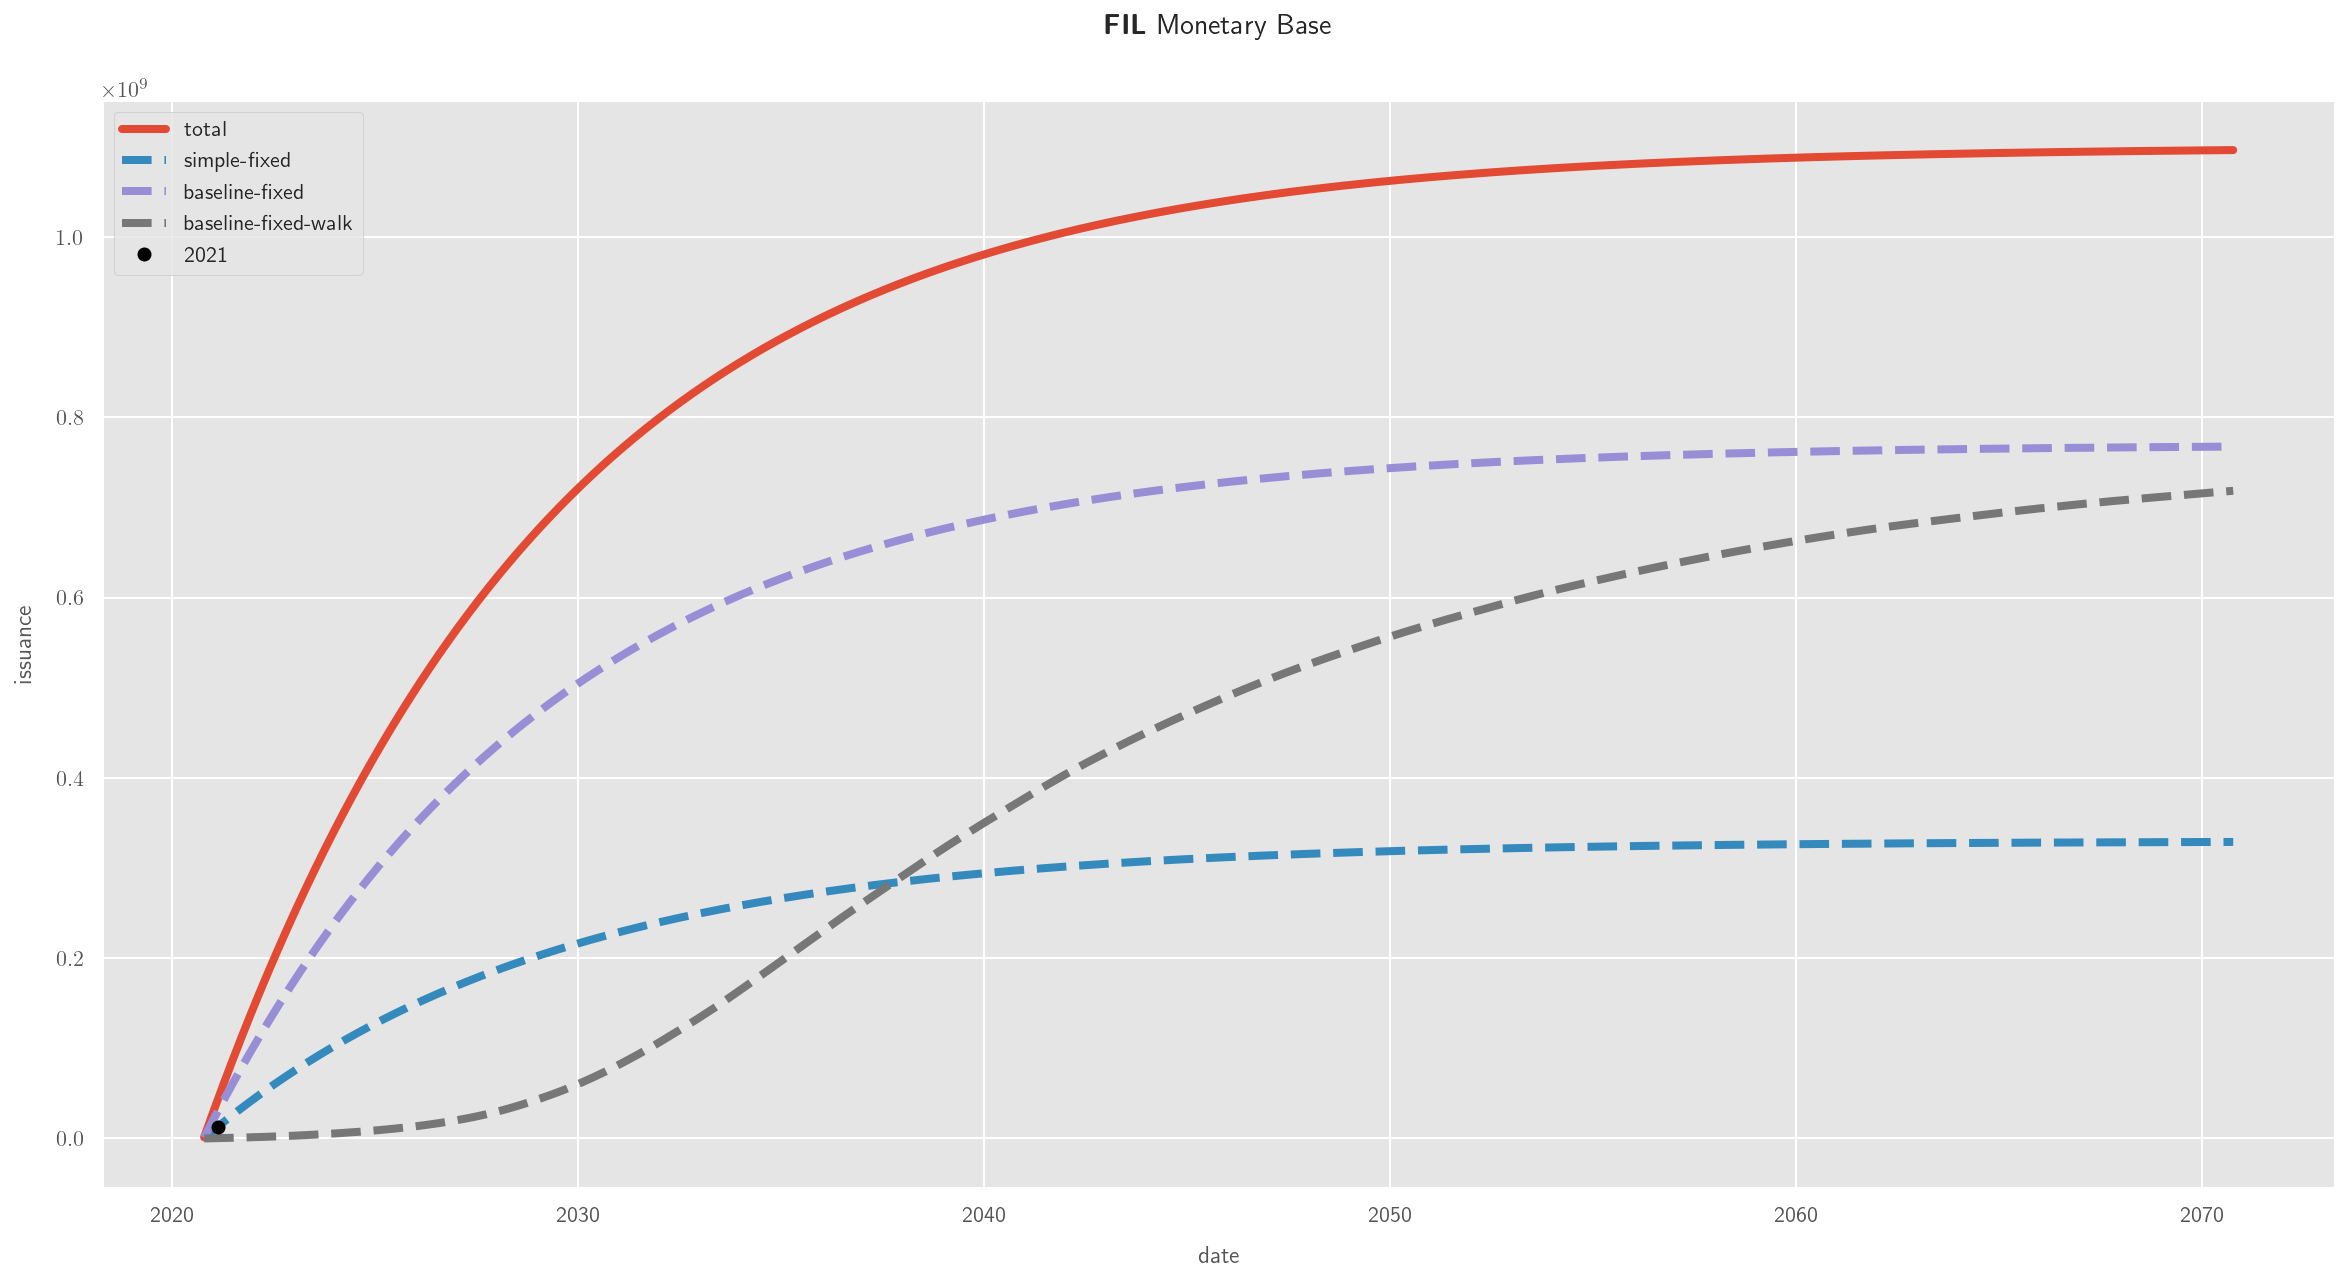

In [132]:
plot_fil_supply_curve(supply)

## Standardize Time Series

In [11]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 6876 lines to file ../output-data/FIL_weekly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,577,28850.0,0.137381,2020-10-01
2,FIL,1585,79250.0,0.377381,2020-10-01
3,FIL,2593,129650.0,0.617381,2020-11-01
4,FIL,3601,180050.0,0.857381,2020-11-01


,coin,block,total_supply,total_supply_pct,date
6871,FIL,6925537,2.100000e+07,100.0,2152-06-01
6872,FIL,6926545,2.100000e+07,100.0,2152-06-01
6873,FIL,6927553,2.100000e+07,100.0,2152-07-01
6874,FIL,6928561,2.100000e+07,100.0,2152-07-01
6875,FIL,6929569,2.100000e+07,100.0,2152-07-01


In [12]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1582 lines to file ../output-data/FIL_monthly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,2449,122450.0,0.583095,2020-11-01
2,FIL,6769,338450.0,1.611667,2020-12-01
3,FIL,11233,561650.0,2.674524,2021-01-01
4,FIL,15697,784850.0,3.737381,2021-02-01


,coin,block,total_supply,total_supply_pct,date
1577,FIL,6909697,2.100000e+07,100.0,2152-03-01
1578,FIL,6914161,2.100000e+07,100.0,2152-04-01
1579,FIL,6918481,2.100000e+07,100.0,2152-05-01
1580,FIL,6922945,2.100000e+07,100.0,2152-06-01
1581,FIL,6927265,2.100000e+07,100.0,2152-07-01


In [13]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 133 lines to file ../output-data/FIL_yearly.csv


,coin,block,total_supply,total_supply_pct,date
0,FIL,1,50.0,0.000238,2020-10-01
1,FIL,11233,561650.0,2.674524,2021-01-01
2,FIL,63793,3189650.0,15.188810,2022-01-01
3,FIL,116353,5817650.0,27.703095,2023-01-01
4,FIL,168913,8445650.0,40.217381,2024-01-01


,coin,block,total_supply,total_supply_pct,date
128,FIL,6690673,2.100000e+07,100.0,2148-01-01
129,FIL,6743377,2.100000e+07,100.0,2149-01-01
130,FIL,6795937,2.100000e+07,100.0,2150-01-01
131,FIL,6848497,2.100000e+07,100.0,2151-01-01
132,FIL,6901057,2.100000e+07,100.0,2152-01-01
